In [ ]:
import pandas as pd
import numpy as np

# Load Excel file
file_path = '/Users/paulina./Downloads/data.xlsx'

# Target columns
target_columns = [
    'Source reference', 'Ksat', 'Bulk density', 'Very coarse', 'Coarse', 'Medium',
    'Fine', 'Very fine', 'Sand (%)', 'Silt  (%)', 'Clay (%)', 'Organic matter'
]
target_columns_clean = [col.strip() for col in target_columns]

# Read all sheets without headers
sheets_dict = pd.read_excel(file_path, sheet_name=None, header=None)
exclude_sheets = {'All data', 'Refrences'}
filtered_sheets = {}

# Find sheets with the right header and extract columns
for sheet_name, df in sheets_dict.items():
    if sheet_name in exclude_sheets:
        continue

    header_row_index = None
    for i, row in df.iterrows():
        row_values = row.fillna("").astype(str).str.strip().tolist()
        if set(target_columns_clean).intersection(set(row_values)) and "Ksat" in row_values:
            header_row_index = i
            break

    if header_row_index is not None:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=header_row_index)
        df.columns = df.columns.str.strip()
        available_cols = [col for col in target_columns_clean if col in df.columns]
        filtered_sheets[sheet_name] = df[available_cols]

# Combine all sheets
combined_df = pd.concat(filtered_sheets.values(), ignore_index=True)

# Clean and convert string values to float
def safe_to_float(val):
    try:
        val = str(val).strip()
        val = val.replace(",", "").replace("%", "")
        if val.lower() in {"", "nan", "none", ".", "-", "e"}:
            return np.nan
        return float(val)
    except Exception:
        return np.nan

for col in combined_df.columns:
    if col != 'Source reference':
        combined_df[col] = combined_df[col].apply(safe_to_float)

# drop rows with missing values if needed
combined_df.dropna(inplace=True)

# Data is ready
print(combined_df.dtypes)
print(combined_df.head())


/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension

Source reference    float64
Ksat                float64
Bulk density        float64
Very coarse         float64
Coarse              float64
Medium              float64
Fine                float64
Very fine           float64
Sand (%)            float64
Silt  (%)           float64
Clay (%)            float64
Organic matter      float64
dtype: object
   Source reference          Ksat  Bulk density  Very coarse  Coarse  Medium  \
0               1.0  7.630000e-06          1.24          3.5     6.0     5.2   
1               1.0  4.310000e-06          1.45          2.9     3.8     3.6   
2               1.0  3.740000e-06          1.35          6.1     4.7     5.2   
3               1.0  1.140000e-08          1.41          1.6     1.4     1.4   
4               1.0  1.450000e-06          1.25          6.1     4.5     4.9   

   Fine  Very fine  Sand (%)  Silt  (%)  Clay (%)  Organic matter  
0   6.3        4.9      25.8       59.4      14.8             5.5  
1   2.9        3.0      16.1     

/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/paulina./Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.4262
[200]	valid_0's rmse: 4.02169
[300]	valid_0's rmse: 3.86246
[400]	valid_0's rmse: 3.73757
[500]	valid_0's rmse: 3.59676
[600]	valid_0's rmse: 3.43603
[700]	valid_0's rmse: 3.2572
[800]	valid_0's rmse: 3.10188
[900]	valid_0's rmse: 2.95684
[1000]	valid_0's rmse: 2.83943
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.83943
R² Score: 0.9427800935362117
MAE: 2.0834327890727202
MSE: 8.062342276716313


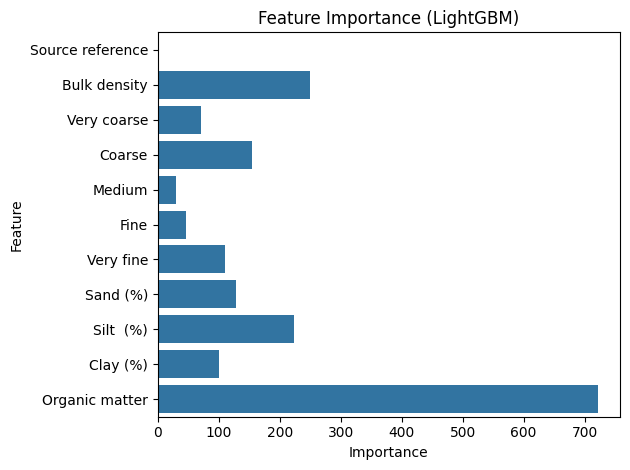

In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import early_stopping, log_evaluation

# Set target and features
target_col = 'Ksat'
feature_cols = [col for col in combined_df.columns if col != target_col]

X = combined_df[feature_cols]
y = combined_df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

# Train model with callbacks 
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# Predict and evaluate
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Feature importance plot
importances = model.feature_importance()
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



In [20]:
combined_df.shape

(96, 12)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 2.56182
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 3.49173
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 3.19557
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 4.30495
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 2.66841
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 5.46845
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 4.90158
Training until validation scores don't improve for 10 rounds
Did not m

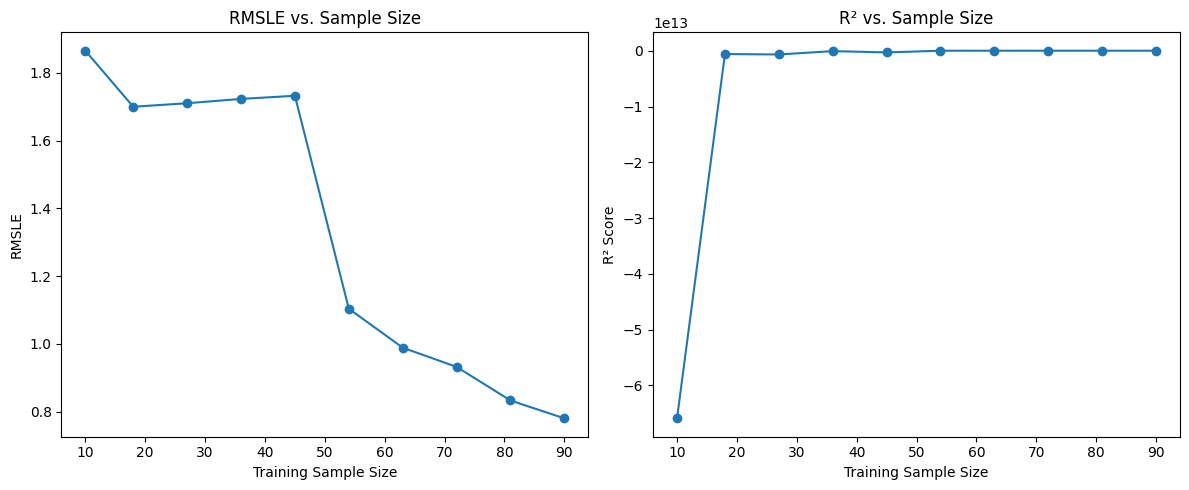

In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_log_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping

# Make sure your data is clean and defined
target_col = "Ksat"
feature_cols = [col for col in combined_df.columns if col != target_col]

X = combined_df[feature_cols]
y = combined_df[target_col]

# Evaluation storage
rmsle_results = {}
r2_results = {}

# Subset sizes: test from 90 down to 10 samples
subset_steps = np.linspace(90, 10, num=10, dtype=int)

# Repeat for stability
repeats = 50

for size in subset_steps:
    rmsle_list = []
    r2_list = []
    for _ in range(repeats):
        # Random subset of data
        subset = combined_df.sample(n=size, random_state=None)
        X_subset = subset[feature_cols]
        y_subset = subset[target_col]

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=None)

        # LightGBM Dataset
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

        # Params
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
            'num_leaves': 15,
            'verbose': -1,
            'seed': 42
        }

        # Model training
        model = lgb.train(
            params,
            train_data,
            valid_sets=[test_data],
            num_boost_round=100,
            callbacks=[early_stopping(stopping_rounds=10)]
        )

        # Predict
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # Evaluation metrics
        rmsle = np.sqrt(mean_squared_log_error(y_test.clip(lower=0), np.clip(y_pred, a_min=0, a_max=None)))
        r2 = r2_score(y_test, y_pred)

        rmsle_list.append(rmsle)
        r2_list.append(r2)

    rmsle_results[size] = np.mean(rmsle_list)
    r2_results[size] = np.mean(r2_list)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(rmsle_results.keys()), list(rmsle_results.values()), marker='o')
plt.xlabel("Training Sample Size")
plt.ylabel("RMSLE")
plt.title("RMSLE vs. Sample Size")

plt.subplot(1, 2, 2)
plt.plot(list(r2_results.keys()), list(r2_results.values()), marker='o')
plt.xlabel("Training Sample Size")
plt.ylabel("R² Score")
plt.title("R² vs. Sample Size")

plt.tight_layout()
plt.show()
